# Indirect Method for optimal control problem with fixed final time

(Example from Kirk 6.2.2)

Yuri Shimane, 2020.08.17

### Continuous stirred-tank chemical reactor problem (fixed final time, Lagrange cost function)

The continous stirred-tank chemical reactor problem is solved via the indirect method as a two-point boundary value problem (TPBVP), using the ```scipy.integrate.solve_bvp()``` function. 
This problem consists of:
- nonlinear dynamics
- fixed final time $t_f$
- fixed initial states, free final states
- no Mayer term in the cost function
- unconstrained states and controls

https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_bvp.html

---

This problem is treated in *Optimal Control Theory: An Introduction* by Donald E. Kirk (pg.338~), and dealt in detail in Luus et al, 1967. *The Control of Nonlinear Systems. Part II: Convergence by Combined First and Second Variations*. 
It consists of a irreversible, exothermic reaction happening in a rector, which must be controlled via a cooling fluid flow actuated with a cooling coil inserted in the reactor. 

State equations:

$$
\begin{align}
\dot{x}_1(t) =& -2\left[ x_1(t) + 0.25 \right] + \left[x_2(t) + 0.5 \right] \exp{\left[ \dfrac{25x_1(t)}{x_1(t)+2} \right]} - \left[ x_1(t) + 0.25\right] u(t)
\\
\dot{x}_2(t) =& 0.5 - x_2(t) - \left[x_2(t) + 0.5 \right] \exp{\left[ \dfrac{25x_1(t)}{x_1(t)+2} \right]}
\end{align}
$$

with initial conditions $\mathbf{x}(0) = \left[0.05, 0 \right]^T$ and free terminal conditions. 
The cost function is given by 

$$
J = \int_{0}^{t_f} \left[ x_1^2(t) + x_2^2(t) + Ru^2(t) \right] dt
$$

where $R=0.1$ is a weighting factor, and $t_f = 0.78$ is the fixed final time. 
The Hamiltonian of the system is given by

$$
\begin{align}
H(\mathbf{x}(t), \mathbf{u}(t), \mathbf{p}(t)) =& x_1^2(t) + x_2^2(t) + Ru^2(t)  \\
    & + p_1(t) \left[ -2 \left[x_1(t) + 0.25 \right] + \left[ x_2(t) + 0.5 \right] \exp{\left[ \dfrac{25 x_1(t)}{x_1(t) + 2} \right]} - \left[ x_1(t) + 0.25\right]u(t) \right]  \\
    & + p_2(t) \left[ 0.5 - x_2(t) - \left[ x_2(t) + 0.5 \right] \exp{\left[ \dfrac{25 x_1(t)}{x_1(t) + 2} \right]} \right]
\end{align}
$$

From necessary condition of optimal control, the ODEs for the costates are given by

$$
\begin{align}
\dot{p}_1(t) =& \dfrac{\partial H}{\partial x_1} \\
             =& -2 x_1(t) + 2p_1(t) + p_1(t) \left[ x_2(t) + 0.5\right] \left[ \dfrac{50}{(x_1(t)+2)^2} \right] \exp{\left[ \dfrac{25 x_1(t)}{x_1(t) + 2} \right]}   \\
              &+ p_1(t)u(t) + p_2(t) \left[ x_2(t) + 0.5 \right] \left[ \dfrac{50}{(x_1(t)+2)^2} \right] \exp{\left[ \dfrac{25 x_1(t)}{x_1(t) + 2} \right]}
\\
\dot{p}_2(t) =& \dfrac{\partial H}{\partial x_2} \\
             =& -2 x_2(t) - p_1(t) \exp{\left[ \dfrac{25 x_1(t)}{x_1(t) + 2} \right]}
                + p_2(t) \left[ 1 + \exp{\left[ \dfrac{25 x_1(t)}{x_1(t) + 2} \right]} \right]
\end{align}
$$

and the algebraic relation

$$
\dfrac{\partial H}{\partial u} = 2 R u(t) - p_1(t) \left[ x_1(t) + 0.25 \right] = 0
$$

must be satisfied from Pontryagin's Minimum Principle. Reorganizing this expression, the control $u$ is given by

$$
u(t) = \dfrac{p_1(t) \left[ x_1(t) + 0.25 \right]}{2R}
$$

which may replace the expression for the ODE for $\dot{x}_1$. 
In general, the terminal conditions of the costates for a free final state are given by

$$
\mathbf{p}(t_f) = \dfrac{\partial h( \mathbf{x}(t_f) )}{\partial \mathbf{x}}
$$

where $h$ is the Mayer term; since in this case, there is no Mayer term associated to $J$, $\mathbf{p}(t_f) = 0$. 


In [1]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 16

In [2]:
R = 0.1   # parameter
def ode_stirredtank(t, y):
    """ODE function must return array with shape (n,m), in the same layout as y"""
    n, m = y.shape
    for j in range(m):
        state = y[:,j]
        # unpack y
        x1 = state[0]   # state x1 at j^th time
        x2 = state[1]   # state x2 at j^th time
        p1 = state[2]   # costate of x1 at j^th time
        p2 = state[3]   # costate of x2 at j^th time
        
        # group terms to simplify expression
        c1 = x1 + 0.25
        c2 = x2 + 0.5
        c3 = np.exp(25*x1/(x1+2))
        c4 = 50/(x1+2)**2
        
        # compute control term as expression based on states and costates
        u  = p1 * c1 / (2*R)
        
        # initialize space for derivatives
        dstate = np.zeros(len(state),)
        # state ODE's
        dstate[0] = -2*c1 + c2*c3 - c2*u
        dstate[1] = 0.5 - x2 - c2*c3
        # costate ODE's
        dstate[2] = -2*x1 + 2*p1 - p1*c2*c4*c3 + p1*u + p2*c2*c4*c3
        dstate[3] = -2*x2 - p1*c3 + p2*(1 + c3)
        if j == 0:
            dy = np.reshape(dstate, (4,1))
        else:
            dy = np.concatenate((dy, np.reshape(dstate, (4,1)) ), axis=1)
    return dy

In [3]:
def bc_stirredtank(ya, yb):
    """Boundary conditions must have shape (n+k,), where ya & yb have shape (n,), and p has shape (k,)"""
    res = np.zeros(4,)
    # initial time boundary conditions
    res[0] = ya[0] - 0.05
    res[1] = ya[1] - 0
    # final time boundary conditions
    res[2] = yb[2] - 0
    res[3] = yb[3] - 0
    return res

In [4]:
tf = 0.78   # final time
# prepare time-domain mesh
x = np.linspace(0, tf, 50)
# prepare initial geuss
y = np.zeros((4, x.size))
for j in range(x.size):  # modify initial guess slightly (may be commented out)
    y[2,j] = 0.5
    y[3,j] = 0.5

In [5]:
n, m = y.shape
m

50

In [6]:
sol = solve_bvp(fun=ode_stirredtank, bc=bc_stirredtank, x=x, y=y, verbose=2, bc_tol=1e-12)

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          4.59e-05       1.70e-20          50              0       
Solved in 1 iterations, number of nodes 50. 
Maximum relative residual: 4.59e-05 
Maximum boundary residual: 1.70e-20


In [7]:
# unpack solution
sol_mesh = sol.x
sol_mat = sol.y
x1_star = sol_mat[0,:]
x2_star = sol_mat[1,:]
p1_star = sol_mat[2,:]
p2_star = sol_mat[3,:]

# reconstruct u
ustar = p1_star * (x1_star + 0.25) / (2*R)

# reconstruct cost
mesh_length = len(sol_mesh)
j_star = 0.0
for j in range(mesh_length):
    j_star += x1_star[j]**2 + x2_star[j]**2 + R*ustar[j]**2
j_star = j_star * tf/mesh_length

In [8]:
j_star

0.011587840252788938

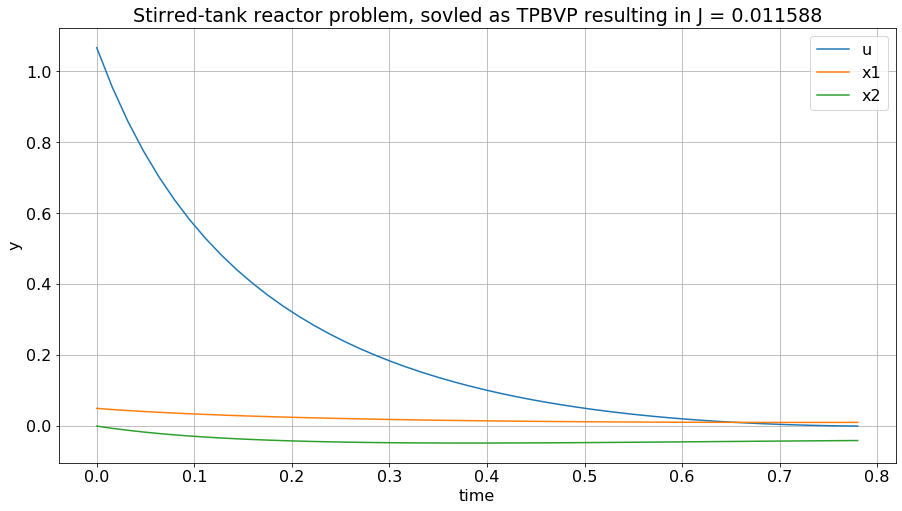

In [9]:
plt.figure(1, figsize=(15, 8))
plt.title(f"Stirred-tank reactor problem, sovled as TPBVP resulting in J = {j_star:2.6f}")
plt.plot(sol_mesh, ustar, label="u")
plt.plot(sol_mesh, x1_star, label="x1")
plt.plot(sol_mesh, x2_star, label="x2")
plt.xlabel("time")
plt.ylabel("y")
plt.legend()
plt.grid(which="both")
plt.show()